## DANN
<배경 지식>
- 학습 법 요약: label predictor (classifier)의 역할은 잘하도록 유지하되 sample의 feature representation이 source domain에서 왔는지 target domain에서 왔는지를 구별 못하게 domain discriminator를 약화하는 방향(gradient reverse @backprop)으로 학습시키겠다는 것
- 아래 SVHN, MNIST 예제를 예로 들면 두 데이터 셋은 10개의 클래스 분류가 가능한 데이터 셋이고, 0 ~9 까지 숫자의 클래스 분류는 수행 가능하되, MNIST, SVHN 중 어느 데이터 셋으로 부터 왔는지는 구분할 수 없게 학습을 진행
- (위와 같이 학습하는 이유는 상대적으로 데이터를 구하기 힘든 데이터 셋에서 이와 유사하면서도 상대적으로 쉽게 구할 수 있는 데이터 셋을 이용해 학습 효과를 얻기 위해서 domain adaptation 학습 법을 사용한다)
  
- 수식으로 표현하면: DANN Loss는 class label 분류 학습과 함께 domain 분류를 진행하되 domain 분류 layer의 gradient에 음수 배를 취하여 domain 간의 거리를 줄이도록 학습을 유도한다.
  
- 아래 예시에서는 MNIST(Source)를 SVHN(Target)에 domain adaptation 하는 예제이다

![img](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbpRiJm%2FbtrOwkX7ud0%2FtOWDFi7JjyWvtG5s56O5D1%2Fimg.jpg)

#### 수식 상세
X  : input space, Y={0,⋯,L−1} : set of L possible labels일 때,  
  
$ \mathbb{D}_S: source~domain~~~~\mathbb{D}_T: target~domain $  
  
비지도 학습 DA의 경우 S에 대해서는 라벨이 존재하지만, T에 대해서는 label이 전혀 없는 상황이면  
  
$ S = \{ (x_i,y_i) \}_{i=1}^n  \overset{i.i.d.}{\sim} (\mathbb{D}_S)^n;~~T=\{x_i\}_{i=n+1}^N  \overset{i.i.d.}{\sim} (\mathbb{D}_T^X)^{n'} $  
  
전체 셈플 수는 위의 수식에 나와 있는 것 처럼 N = n + n' 개 이고  
  
분류기 $ \eta: X\rightarrow Y $ 를 만드는데, $ \mathbb{D}_T $의 라벨이 없어도, 아래의 Target Risk가 낮도록 학습한다.  
  
$ R_{\mathbb{D}_T}(\eta)=\Pr_{(x,y)\sim\mathbb{D}_T}\left( \eta(x) \neq y \right) $

### 1. 데이터 로드

In [1]:
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (1.0,))
])

# RGB -> GRAY 및 28 * 28 사이즈 변환
svhn_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.CenterCrop(28),
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (1.0,))
])

In [2]:
from torchvision.datasets import MNIST, SVHN
import torch.utils.data as data_utils
import torch

download_root = './data'

train_mnist = MNIST(download_root, transform=mnist_transform, train=True, download=True)
test_mnist = MNIST(download_root, transform=mnist_transform, train=False, download=True)

svhn = SVHN(download_root, transform=svhn_transform, download=True)

# target domain 데이터 train 6만개, test 1만개 활용
train_indices = torch.arange(0, 60000)
test_indices = torch.arange(60000, 70000)
train_svhn = data_utils.Subset(svhn, train_indices)
test_svhn = data_utils.Subset(svhn, test_indices)

Using downloaded and verified file: ./data\train_32x32.mat


### 2. 모델 선언

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1)
        self.fc = nn.Linear(4 * 4 * 20, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # (batch, 1, 28, 28) -> (B, 10, 24, 24)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # (B, 10, 24, 24) -> (B, 10, 12, 12)
        x = F.relu(self.conv2(x)) # (batch, 10, 12, 12) -> (batch, 20, 8, 8)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # (batch, 20, 8, 8) -> (batch, 20, 4, 4)
        x = x.view(-1, 4 * 4 * 20) # (batch, 20, 4, 4) -> (batch, 320)
        x = F.relu(self.fc(x)) # (batch, 320) -> (batch, 100)
        return x # (batch, 100)

class GradReverse(torch.autograd.Function):
    def forward(self, x):
        return x.view_as(x)

    def backward(self, grad_output):
        return (grad_output * -1) # 역전파 시에 gradient에 음수를 취함

class domain_classifier(nn.Module):
    def __init__(self):
        super(domain_classifier, self).__init__()
        self.fc1 = nn.Linear(100, 10)
        self.fc2 = nn.Linear(10, 1) # mnist = 0, svhn = 1 회귀 가정

    def forward(self, x):
        x = GradReverse.apply(x) # gradient reverse
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(x)

class label_classifier(nn.Module):
    def __init__(self):
        super(label_classifier, self).__init__()
        self.fc1 = nn.Linear(100, 25)
        self.fc2 = nn.Linear(25, 10) # class 개수 = 10개

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
class DANN_CNN(nn.Module):
    def __init__(self, CNN):
        super(DANN_CNN, self).__init__()

        self.cnn = CNN() # CNN 구조 모델 받아오기

        self.domain_classifier = domain_classifier() # 도메인 분류 layer, 도메인 분류시에는 Gradient에 음수를 취한다.

        self.label_classifier = label_classifier() # 숫자 0 ~ 9 클래스 분류 layer

    def forward(self, img):
        cnn_output = self.cnn(img) # (B, 100)

        domain_logits =  self.domain_classifier(cnn_output) # (batch, 100) -> (batch, 1)

        label_logits = self.label_classifier(cnn_output) # (batch, 100) -> (batch, 10)

        return domain_logits, label_logits

### 3. LOSS
- domain 분류 및 class 분류 loss를 혼합한 DANN loss 함수
- alpha는 domain 분류 loss 함수의 가중치로 하이퍼파라미터이다

In [14]:
class DANN_LOSS(nn.Module):
    def __init__(self):
        super(DANN_LOSS, self).__init__()
        self.CE = nn.CrossEntropyLoss() # 0~9 class 분류용
        self.BCE = nn.BCELoss() # 도메인 분류용

    # result : DANN_CNN에서 반환된 값
    # label : 숫자 0 ~ 9에 대한 라벨
    # domain_num : 0(mnist) or 1(svhn)

    def forward(self, result, label, domain_num, alpha=1):
        domain_logits, label_logits = result

        batch_size = domain_logits.shape[0]

        domain_target = torch.FloatTensor([domain_num] * batch_size).unsqueeze(1).to(device)

        domain_loss = self.BCE(domain_logits, domain_target)  # domain 분류 loss
        target_loss = self.CE(label_logits, label) # class 분류 loss

        loss = target_loss + alpha * domain_loss

        return loss

### 4. Training

In [15]:
from torch.optim.lr_scheduler import LinearLR
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

batch_size = 64

# dataloader 선언
mnist_loader = DataLoader(dataset=train_mnist, 
                         batch_size=batch_size,
                         shuffle=True)

svhn_loader = DataLoader(dataset=train_svhn, 
                         batch_size=batch_size,
                         shuffle=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

my_cnn = CNN()

model = DANN_CNN(my_cnn).to(device) # 모델은 미리 GPU에 업로드??
loss_fn = DANN_LOSS().to(device)

epochs = 10

model.train()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters=epochs * len(mnist_loader))
alpha = 0.5

for i in range(1, epochs + 1):
    total_loss = 0

    for step in tqdm(range(len(mnist_loader))):
        # mnist, svhn 에서 1B 씩 가져오기
        src_data = next(iter(mnist_loader))
        tgt_data = next(iter(svhn_loader))

        # 각 batch 내 데이터 : 0번은 이미지 픽셀 값, 1번은 0 ~ 9 class 라벨 값
        mnist_data = src_data[0].to(device)
        mnist_target = src_data[1].to(device)

        svhn_data = tgt_data[0].to(device)
        svhn_target = tgt_data[1].to(device)

        # 순전파 결과 구하기
        source_result = model(mnist_data)
        target_result = model(svhn_data)

        # 순전파 결과, class label, domain label(0 = mnist, 1 = svhn), alpha 순서
        source_loss = loss_fn(source_result, mnist_target, 0, alpha = alpha)
        target_loss = loss_fn(target_result, svhn_target, 1, alpha = alpha)

        loss = source_loss + target_loss # 두개의 loss를 합친다???

        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    print('Epoch : %d, Avg Loss : %.4f'%(i, total_loss / len(mnist_loader)))

torch.save(model.state_dict(), './dann.py')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 1, Avg Loss : 3.3478


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 2, Avg Loss : 2.3484


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 3, Avg Loss : 1.9194


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 4, Avg Loss : 1.6782


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 5, Avg Loss : 1.5495


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 6, Avg Loss : 1.5096


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 7, Avg Loss : 1.4969


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 8, Avg Loss : 1.4631


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 9, Avg Loss : 1.4108


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 10, Avg Loss : 1.4148


### 5. Test

In [23]:
batch_size = 64

mnist_loader_test = DataLoader(dataset=test_mnist, 
                         batch_size=batch_size)

svhn_loader_test = DataLoader(dataset=test_svhn, 
                         batch_size=batch_size)

model = DANN_CNN(my_cnn).to(device)
model.load_state_dict(torch.load('./dann.pt')) # torch.load()는 역직렬화
model.eval()

'''
# ref1) https://stackoverflow.com/questions/42703500/how-do-i-save-a-trained-model-in-pytorch
# ref2) https://tutorials.pytorch.kr/beginner/saving_loading_models.html

# 만약 pretrained_dict이 설계한 모델과 일부 틀리다면

# filter out unne
'''

m_correct = 0
s_correct = 0

for step in tqdm(range(len(mnist_loader_test))):

    source_data = next(iter(mnist_loader_test))
    target_data = next(iter(svhn_loader_test))

    mnist_data = source_data[0].to(device)
    mnist_target = source_data[1].to(device)

    svhn_data = target_data[0].to(device)
    svhn_target = target_data[1].to(device)

    # domain 분류와 관련된 logits은 사용하지 않기에 _로 받아서 처리
    _, mnist_logits = model(mnist_data)
    _, svhn_logits = model(svhn_data)

    # 정확도 산출을 위하여 정답 개수 누적
    m_correct += torch.sum(torch.argmax(mnist_logits, 1) == mnist_target).item()
    s_correct += torch.sum(torch.argmax(svhn_logits, 1) == svhn_target).item()


print('MNIST Test Accuracy : %.2f%%'%(m_correct * 100 / (len(mnist_loader_test) * batch_size)))
print('SVHN Test Accuracy : %.2f%%'%(s_correct * 100 / (len(svhn_loader_test) * batch_size)))


  0%|          | 0/157 [00:00<?, ?it/s]

MNIST Test Accuracy : 100.00%
SVHN Test Accuracy : 78.12%


### 6. Domain Embedding Space 시각화
- DANN Loss를 통해 두 domain의 임베딩 space가 가까워 졌는지 살펴본다
- 가장 앞 batch의 250개씩의 데이터만 샘플링 하여 100차원 벡터를 구해본다.

In [27]:
mnist_loader = DataLoader(dataset=train_mnist, 
                         batch_size=250,
                         shuffle=True)

svhn_loader = DataLoader(dataset=train_svhn, 
                         batch_size=250,
                         shuffle=True)

source_data = next(iter(mnist_loader))
target_data = next(iter(svhn_loader))

mnist_data = source_data[0].to(device)
mnist_target = source_data[1].to(device)

svhn_data = target_data[0].to(device)
svhn_target = target_data[1].to(device)

mnist_vector = model.cnn(mnist_data) # 학습된 모델의 CNN 부분만 활용(100차원 임베딩 벡터를 받아오는 과정)
svhn_vector = model.cnn(svhn_data)

# 임베딩 결과를 가져와 2차원 t-SNE 임베딩을 구하는 코드

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

df = pd.DataFrame(np.concatenate([mnist_vector.cpu().detach().numpy(), svhn_vector.cpu().detach().numpy()], 0))
tsne_np = TSNE(n_components=2).fit_transform(df)
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])

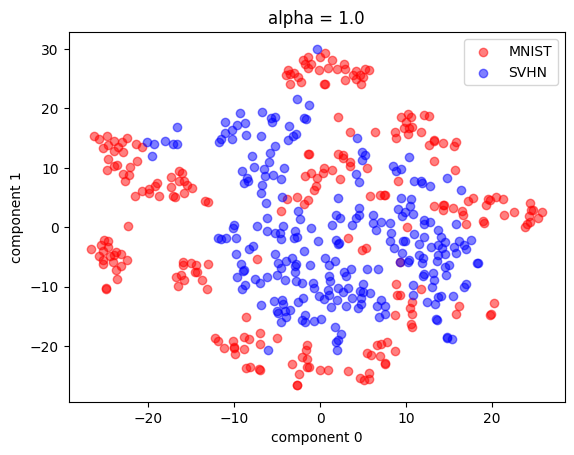

In [28]:
import matplotlib.pyplot as plt

tsne_df_0 = tsne_df.loc[:250]
tsne_df_1 = tsne_df.loc[250:]

plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color = 'red', label = 'MNIST', alpha = 0.5)
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = 'blue', label = 'SVHN', alpha = 0.5)
plt.title('alpha = 1.0')
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

```
CustomMetricLearning
    |-lib
        dataset.py
        |-models
            dann.py
    dann_trainer.py
    main.py
```

In [ ]:
# CustomMetricLearning/main.py
import argparse, os, sys, yaml
from datetime import datetime
import torch

sys.path.append(".")

from dann_trainer import DomainAdaptationTrainer
from triplet_trainer import TripletTrainer
from trainer import Trainer


def read_config(file):
    with open(file, "r") as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
        config["datetime"] = datetime.today().strftime("%d%m%y-%H%M")
        #os.environ["CUDA_VISIBLE_DEVICES"] = config["device_ids"]
        config["device"] = "cuda" if torch.cuda.is_available() else "cpu"
        
        # if config["normalize"] is None:
        #     config["normalize"] = get_normalize_params(config["dataroot"], config["img_size"])
        
        config = argparse.Namespace(**config)
    
    return config


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--model", type=str, default="DANN")
    parser.add_argument("--cfg", type=str, default="D:/001_Code/WG1/hdmap_inspector_models/CustomMetricLearning/configs/dann.yaml")
    args = parser.parse_args()
    
    cfg = read_config(args.cfg)
    if args.model == "DANN":
        trainer = DomainAdaptationTrainer(cfg) # #src는 lasTopView, tgt는 TopView HDMap 에 도메인 적응을 수행한다.
    elif args.model == "Triplet":
        trainer = TripletTrainer(cfg)
    elif args.model == "Dual":
        trainer = Trainer(cfg)
    else:
        raise NotImplementedError
    
    trainer.run()

In [ ]:
# CustomMetricLearning/dann_trainer.py 
class DomainAdaptationTrainer:
    def __init__(self, config) -> None:
        self.config = config
        os.makedirs(self.config.work_dir, exist_ok=True)
        
        self.model = DANN(config.emb_dim).to(self.config.device)
        self.model = torch.nn.DataParallel(self.model)
        
        trn_ds = DomainAdaptationDataset(config, config.train_split)
        val_ds = DomainAdaptationDataset(config, config.valid_split)
        
        self.trn_loader = DataLoader(trn_ds, batch_size=config.batch_size, num_workers=4, shuffle=True)
        self.val_loader = DataLoader(val_ds, batch_size=config.batch_size, num_workers=4, shuffle=False)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config.lr)
        self.writer = SummaryWriter(os.path.join(self.config.work_dir, self.config.datetime))
        
    def train_step(self, source, target):
        source = source.to(self.config.device)
        target = target.to(self.config.device)
        
        self.optimizer.zero_grad()
        
        source_domain_output = self.model(source)
        source_domain_labels = torch.zeros((source.size(0), )).unsqueeze(-1).to(self.config.device)
        source_loss = F.binary_cross_entropy_with_logits(source_domain_output, source_domain_labels)
        
        target_domain_output = self.model(target)
        target_domain_labels = torch.ones((target.size(0), )).unsqueeze(-1).to(self.config.device)
        target_loss = F.binary_cross_entropy_with_logits(target_domain_output, target_domain_labels)
        
        total_loss = source_loss + target_loss
        total_loss.backward()
        
        self.optimizer.step()
        return source_loss.item(), target_loss.item()
    
    def valid_step(self, source, target):
        source = source.to(self.config.device)
        target = target.to(self.config.device)
        
        source_domain_output = self.model(source)
        source_domain_labels = torch.zeros((source.size(0), )).unsqueeze(-1).to(self.config.device)
        source_loss = F.binary_cross_entropy_with_logits(source_domain_output, source_domain_labels)
        
        target_domain_output = self.model(target)
        target_domain_labels = torch.ones((target.size(0), )).unsqueeze(-1).to(self.config.device)
        target_loss = F.binary_cross_entropy_with_logits(target_domain_output, target_domain_labels)
        
        return source_loss.item(), target_loss.item()
    
    def run(self):
        
        best_loss = torch.inf
        for epoch in range(1, self.config.epochs + 1):
            trn_src_loss = 0.
            trn_tgt_loss = 0.
            val_src_loss = 0.
            val_tgt_loss = 0.

            self.model.train()
            trn_iterator = tqdm(self.trn_loader, desc=f"TRAIN {epoch}")
            for idx, (src, tgt) in enumerate(trn_iterator):
                src_loss, tgt_loss = self.train_step(src, tgt) #src는 lasTopView, tgt는 TopView HDMap
                trn_src_loss += src_loss
                trn_tgt_loss += tgt_loss
                trn_iterator.set_postfix_str(
                    f"src_loss: {trn_src_loss / (idx+1):.4f}, tgt_loss: {trn_tgt_loss / (idx+1):.4f}"
                )
            self.writer.add_scalar("source_loss/train", (trn_src_loss / (idx+1)), epoch)
            self.writer.add_scalar("target_loss/train", (trn_tgt_loss / (idx+1)), epoch)
            
            self.model.eval()
            val_iterator = tqdm(self.val_loader, desc=f"VALID {epoch}")
            for idx, (src, tgt) in enumerate(val_iterator):
                with torch.no_grad():
                    src_loss, tgt_loss = self.valid_step(src, tgt)
                val_src_loss += src_loss
                val_tgt_loss += tgt_loss
                val_iterator.set_postfix_str(
                    f"src_loss: {val_src_loss / (idx+1):.4f}, tgt_loss: {val_tgt_loss / (idx+1):.4f}"
                )
            self.writer.add_scalar("source_loss/valid", (val_src_loss / (idx+1)), epoch)
            self.writer.add_scalar("target_loss/valid", (val_tgt_loss / (idx+1)), epoch)
                
            current_loss = (val_src_loss + val_tgt_loss) / (idx + 1)
            if best_loss > current_loss:
                best_loss = current_loss
                
                # torch.save(
                #     {"weight": self.model.state_dict(), "cfg": self.config.__dict__},
                #     os.path.join(self.config.work_dir, f"{self.config.datetime}.pt")
                # )
                torch.save(self.model.state_dict(), 
                           os.path.join(self.config.work_dir, f"{self.config.datetime}.pt"))
                with open(os.path.join(self.config.work_dir, f"{self.config.datetime}.yaml"), "w") as f:
                    yaml.dump(self.config.__dict__, f)
                print("Model saved")
            
        self.writer.add_hparams(
            {k: str(v) for k, v in self.config.__dict__.items()}, 
            metric_dict={"loss": best_loss}
        )

In [ ]:
class Embedding(nn.Module):
    def __init__(self, emb_dim=512):
        super(Embedding, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.resnet.fc = nn.Linear(in_features=self.resnet.fc.in_features, out_features=emb_dim)
        
    def forward(self, x):
        x = self.resnet(x)
        return x

# CustomMetricLearning/dann_trainer.py        
class DANN(torch.nn.Module):
    def __init__(self, emb_dim) -> None:
        super().__init__()
        self.embedding_net = Embedding(emb_dim)
        self.domain_classifier = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.Linear(emb_dim, emb_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(emb_dim//2, 1),
        )

    def forward(self, inp):
        emb = self.embedding_net(inp)
        domain_output = self.domain_classifier(emb)
        return domain_output